In [1]:
import numpy as np
from scipy.cluster.vq import kmeans2 
import pylab as plt
plt.style.use('ggplot')
import astropy.units as au
import os

import gpflow as gp
from heterogp.latent import Latent
from gpflow import settings
from gpflow.decors import params_as_tensors,autoflow
from gpflow.quadrature import hermgauss
from gpflow import settings
from gpflow import transforms
from gpflow import logdensities as densities

from gpflow.decors import params_as_tensors
from gpflow.decors import params_as_tensors_for
from gpflow.decors import autoflow
from gpflow.params import Parameter
from gpflow.params import Parameterized
from gpflow.params import ParamList
from gpflow.quadrature import hermgauss
from gpflow.likelihoods import Likelihood
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
import tensorflow as tf

/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/multipledispatch-0.4.9-py3.6.egg/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


In [2]:
from gpflow.actions import Loop, Action
from gpflow.training import AdamOptimizer

class PrintAction(Action):
    def __init__(self, model, text):
        self.model = model
        self.text = text
        
    def run(self, ctx):
        likelihood = ctx.session.run(self.model.likelihood_tensor)
        logging.warning('{}: iteration {} likelihood {:.4f}'.format(self.text, ctx.iteration, likelihood))
#         logging.warning(self.model)
        
def run_with_adam(model, lr, iterations, callback=None):
    
    adam = AdamOptimizer(lr).minimize(model,maxiter=iterations)
    #make_optimize_action(model)
    
#     actions = [adam]#natgrad,
#     actions = actions if callback is None else actions + [callback]

#     Loop(actions, stop=iterations)()
#     model.anchor(model.enquire_session())

from gpflow.training import NatGradOptimizer, AdamOptimizer, XiSqrtMeanVar

def run_nat_grads_with_adam(model, lr, gamma, iterations, var_list=None, callback=None):
    # we'll make use of this later when we use a XiTransform
    if var_list is None:
        var_list = [(model.q_mu, model.q_sqrt)]

    # we don't want adam optimizing these
    model.q_mu.set_trainable(False)
    model.q_sqrt.set_trainable(False)

    adam = AdamOptimizer(lr).make_optimize_action(model)
    natgrad = NatGradOptimizer(gamma).make_optimize_action(model, var_list=var_list)
    
    actions = [adam, natgrad]
    actions = actions if callback is None else actions + [callback]

    Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())
    
    

# Create input data

In [3]:
from ionotomo import *

dp = DataPack(filename='../../data/rvw_datapack_full_phase_dec27_wideband.hdf5')

ant_idx = -1
time_idx = -1
dir_idx = -1
freq_idx = -1

phase = dp.get_phase(ant_idx,time_idx,dir_idx,freq_idx)

times,_ = dp.get_times(time_idx)
antennas,antenna_labels = dp.get_antennas(ant_idx)
freqs = dp.get_freqs(freq_idx)
directions,patch_names = dp.get_directions(dir_idx)
Na,Nt,Nd,Nf = phase.shape

X_d = np.array([directions.ra.deg,directions.dec.deg]).T
X_t = times.mjd[:,None]*86400.#mjs
enu = ENU(obstime=times[0],location=dp.radio_array.get_center())
ant_enu = antennas.transform_to(enu)
X_a = np.array([ant_enu.east.to(au.km).value, ant_enu.north.to(au.km).value]).T

d_std = X_d.std(0).mean() + 1e-6
t_std = X_t.std() + 1e-6
a_std = X_a.std(0).mean() + 1e-6

X_a = (X_a - X_a.mean(0)) / a_std
X_t = (X_t - X_t.mean()) / t_std
X_d = (X_d - X_d.mean(0)) / d_std


def make_coord_array(*X):
    """
    Return the design matrix from coordinates.
    """
    def add_dims(x,where,sizes):
        shape = []
        tiles = []
        for i in range(len(sizes)):
            if i not in where:
                shape.append(1)
                tiles.append(sizes[i])
            else:
                shape.append(-1)
                tiles.append(1)
        return np.tile(np.reshape(x,shape),tiles)
    N = [x.shape[0] for x in X]
    X_ = []

    for i,x in enumerate(X):
        for dim in range(x.shape[1]):
            X_.append(add_dims(x[:,dim],[i], N))
    X = np.stack(X_,axis=-1)
    
    return np.reshape(X,(-1,X.shape[-1]))

def make_data_vec(Y,freqs):
    """
    Takes Y of shape [..., Nf, N]
    returns [...,N+1] where last is freq of observation"""
    shape = Y.shape
    freqs = np.reshape(freqs,
                     np.concatenate([np.ones(len(shape)-2,dtype=np.int32), [shape[-2], 1]],axis=0))#[...,Nf, 1]
    tiles = list(shape)
    tiles[-2] = 1
    freqs = np.tile(freqs,tiles)
    return np.concatenate([Y.reshape((-1,shape[-1])), freqs.reshape((-1,1))],axis=-1)



/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


# Decide on some priors

In [4]:
###
# Using half-normal priors for positive params these should represent limits of distriubtion
DTEC_prior_var = 0.15**2#TECU^2
DTEC_prior_time_ls = 120.#seconds
DTEC_prior_dir_ls = 0.5#degree

DTEC_prior_time_ls /= t_std #unitless
DTEC_prior_dir_ls /= d_std #unitless
print("Time lengthscale: {}".format(DTEC_prior_time_ls))
print("Direction lengthscale: {}".format(DTEC_prior_dir_ls))

Time lengthscale: 0.014433767962233165
Direction lengthscale: 0.19428487737392294


# Define homogeneous model

In [5]:
try:
    @tf.RegisterGradient('WrapGrad')
    def _wrap_grad(op,grad):
        phi = op.inputs[0]
        return tf.ones_like(phi)*grad
except:
    pass#already defined

def wrap(phi):
    out = tf.atan2(tf.sin(phi),tf.cos(phi))
    with tf.get_default_graph().gradient_override_map({'Identity': 'WrapGrad'}):
        return tf.identity(out)
    
from gpflow.quadrature import ndiagquad
from heterogp.latent import Latent

class WrappedPhaseGaussian(gp.likelihoods.Gaussian):
    def __init__(self, freq=140e6, name=None):
        super().__init__(name=name)
        self.num_gauss_hermite_points = 30
        self.freq = tf.convert_to_tensor(freq,dtype=settings.float_type,name='test_freq') # frequency the phase is calculated at for the predictive distribution
        self.tec_conversion = tf.convert_to_tensor(-8.4480e9,dtype=settings.float_type,name='tec_conversion') # rad Hz/ tecu
        self.tec2phase = tf.convert_to_tensor(self.tec_conversion / self.freq,dtype=settings.float_type,name='tec2phase')
    
    
    @params_as_tensors
    def logp(self, F, Y, freqs=None, **unused_kwargs):
        """The log-likelihood function."""
        tec2phase = self.tec_conversion/freqs
        phase = F*tec2phase
        return tf.cos(Y - phase)/self.variance
#         dphase = phase - Y
#         return tf.reduce_logsumexp(tf.stack([-0.5*(dphase + 2*np.pi*2)**2/self.variance,
#                                              -0.5*(dphase + np.pi*2)**2/self.variance,
#                                               -0.5*(dphase)**2/self.variance,
#                                               -0.5*(dphase - np.pi*2)**2/self.variance,
#                                              -0.5*(dphase - 2*np.pi*2)**2/self.variance
#                                              ],axis=-1),axis=-1) - tf.log(np.sqrt(2*np.pi)*tf.sqrt(self.variance))
        
        dphase = wrap(phase - wrap(Y)) # Ito theorem
        return densities.gaussian(dphase, tf.fill(tf.shape(F),tf.cast(0.,settings.float_type)), self.variance)

    
#     @params_as_tensors
#     def logp(self, F, Y, freqs=None, **unused_kwargs):
#         """The log-likelihood function."""
#         tec2phase = self.tec_conversion/freqs
#         phase = wrap(F*tec2phase)
#         dphase = wrap(phase - wrap(Y)) # Ito theorem
#         return densities.gaussian(dphase, tf.fill(tf.shape(F),tf.cast(0.,settings.float_type)), self.variance)

    @params_as_tensors
    def conditional_mean(self, F, eval_freq=None, **unused_kwargs):  # pylint: disable=R0201
        """The mean of the likelihood conditioned on latent."""
        eval_freq = self.freq if eval_freq is None else eval_freq
        tec2phase = self.tec_conversion/eval_freq
        phase = F*tec2phase
        return phase

    @params_as_tensors
    def conditional_variance(self, F, **unused_kwargs):
        return self.variance*tf.fill(tf.shape(F),tf.cast(1.,settings.float_type))
    
    def predict_mean_and_var(self, Fmu, Fvar, **args):
        """
        Given a Normal distribution for the latent function,
        return the mean of Y
        if
            q(f) = N(Fmu, Fvar)
        and this object represents
            p(y|f)
        then this method computes the predictive mean
           \int\int y p(y|f)q(f) df dy
        and the predictive variance
           \int\int y^2 p(y|f)q(f) df dy  - [ \int\int y p(y|f)q(f) df dy ]^2
        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (e.g. Gaussian) will implement specific cases.
        """
        integrand2 = lambda *X, **Ys: self.conditional_variance(*X, **Ys) \
            + tf.square(self.conditional_mean(*X, **Ys))
        E_y, E_y2 = ndiagquad([self.conditional_mean, integrand2],
                self.num_gauss_hermite_points,
                Fmu, Fvar, **args)
        V_y = E_y2 - tf.square(E_y)
        return E_y, V_y
    
    def predict_density(self, Fmu, Fvar, Y, **args):
        """
        Given a Normal distribution for the latent function, and a datum Y,
        compute the (log) predictive density of Y.
        i.e. if
            q(f) = N(Fmu, Fvar)
        and this object represents
            p(y|f)
        then this method computes the predictive density
           \int p(y=Y|f)q(f) df
        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (Gaussian, Poisson) will implement specific cases.
        """
        exp_p = ndiagquad(lambda X, Y, **Ys: tf.exp(self.logp(X, Y,**Ys)),
                self.num_gauss_hermite_points,
                Fmu, Fvar, Y=Y, **args)
        return tf.log(exp_p)

    @params_as_tensors
    def variational_expectations(self, Fmu, Fvar, Y, **args):
        """
        Compute the expected log density of the data, given a Gaussian
        distribution for the function values.
        if
            q(f) = N(Fmu, Fvar)
        and this object represents
            p(y|f)
        then this method computes
           \int (\log p(y|f)) q(f) df.
        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (Gaussian, Poisson) will implement specific cases.
        """
        return ndiagquad(self.logp,
                self.num_gauss_hermite_points,
                Fmu, Fvar, Y=Y, **args)
        

class WrappedPhaseSVGP(gp.models.SVGP):
    def __init__(self, X, Y, kern, likelihood, feat=None,
                 mean_function=None,
                 num_latent=None,
                 q_diag=False,
                 whiten=True,
                 minibatch_size=None,
                 Z=None,
                 num_data=None,
                 **kwargs):
        super(WrappedPhaseSVGP,self).__init__(X, Y, kern, likelihood, feat=feat,
                 mean_function=mean_function,
                 num_latent=num_latent,
                 q_diag=q_diag,
                 whiten=whiten,
                 minibatch_size=minibatch_size,
                 Z=Z,
                 num_data=num_data,
                 **kwargs)
        
    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """

        # Get prior KL.
        KL = self.build_prior_KL()

        # Get conditionals
        fmean, fvar = self._build_predict(self.X, full_cov=False)

        # Get variational expectations.
        lik_freqs = self.Y[:,-1:]

        var_exp = self.likelihood.variational_expectations(fmean, fvar, self.Y[:,:-1], freqs=lik_freqs)

        # re-scale for minibatch size
        scale = tf.cast(self.num_data, settings.float_type) / tf.cast(tf.shape(self.X)[0], settings.float_type)

        return tf.reduce_sum(var_exp) * scale - KL
    
    @autoflow((settings.float_type, [None, None]), (settings.float_type, [None, None]))
    def predict_density(self, Xnew, Ynew):
        """
        Compute the (log) density of the data Ynew at the points Xnew
        Note that this computes the log density of the data individually,
        ignoring correlations between them. The result is a matrix the same
        shape as Ynew containing the log densities.
        """
        pred_f_mean, pred_f_var = self._build_predict(Xnew)
        lik_freqs = Ynew[:,-1:]
        return self.likelihood.predict_density(pred_f_mean, pred_f_var, Ynew[:,:-1], freqs=lik_freqs)
    
    @autoflow((settings.float_type, [None, None]))
    def compute_dtec(self, Xnew):
        """c
        Compute the mean and variance of held-out data at the points Xnew
        """
        return self._build_predict(Xnew)
    
    @autoflow((settings.float_type, [None, None]))
    def predict_y(self, Xnew, eval_freq=None):
        """c
        Compute the mean and variance of held-out data at the points Xnew
        """
        pred_f_mean, pred_f_var = self._build_predict(Xnew)
        return self.likelihood.predict_mean_and_var(pred_f_mean, pred_f_var, eval_freq=eval_freq) 

def make_homo_model(X,Y,freqs,M=None,minibatch_size=None):
    N, num_latent = Y.shape
    _, D = X.shape
    M = M or N
    Z = kmeans2(X, M, minit='points')[0] if N < 10000 else X[np.random.choice(N,size=M,replace=False),:]
    with gp.defer_build():
        likelihood = WrappedPhaseGaussian()
        likelihood.variance = 0.3**2
#         likelihood.variance.prior = gp.priors.Gaussian(0.,0.3**2)# 1 rad^2 bound
        
        kern_time = gp.kernels.RBF(1,active_dims=[0])
        kern_time.lengthscales = DTEC_prior_time_ls
#         kern_time.lengthscales.set_trainable(False)
        kern_time.lengthscales.prior = gp.priors.Gaussian(0.,DTEC_prior_time_ls**2)
        kern_time.variance.prior = gp.priors.Gaussian(0.,DTEC_prior_var)
        kern_space = gp.kernels.RBF(2,active_dims=[1,2])
        kern_space.lengthscales.prior = gp.priors.Gaussian(0.,DTEC_prior_dir_ls**2)
        kern_space.variance.set_trainable(False)
        kern = kern_time*kern_space
        mean = gp.mean_functions.Zero()
        
        model = WrappedPhaseSVGP(X, Y, kern, likelihood,
                 mean_function=mean,
                 num_latent=num_latent-1,
                 q_diag=False,
                 whiten=False,
                 minibatch_size=minibatch_size,
                 Z=Z,
                 num_data=N)
        model.compile()
    return model



# Run a small test on some data

In [146]:
def plot_single(X,Y,Xstar,Ystar,error, ax = None):
    if ax is None:
        fig,ax = plt.subplots(1,1)
    ax.plot(X[:,0],Y[:,0],label='data')
    ax.plot(Xstar[:,0],Ystar[:,0],label='inferred')
    ax.fill_between(Xstar[:,0],Ystar[:,0]+error[:,0],Ystar[:,0]-error[:,0],alpha=0.25)
    ax.legend()

def w(x):
    return np.arctan2(np.sin(x),np.cos(x))


iterations=100
i = 51
k = 1

X = make_coord_array(X_t,X_d[:k,:],freqs[:,None])[:,:-1]# N, 3
Y = make_data_vec(w(phase[i,:,:k,:,None]),freqs)#N2

with tf.Session(graph=tf.Graph()) as sess:
    model = make_homo_model(X,Y,freqs,M=500,minibatch_size=128)
    
#     run_nat_grads_with_adam(model,1e-3,1e-1,iterations,callback=PrintAction(model,"Adam"))

    run_with_adam(model,1e-3,iterations,PrintAction(model,"Adam"))
    
    Xstar = make_coord_array(X_t,X_d[:k,:],freqs[:1,None])[:,:-1]
    ystar,varstar = model.predict_y(Xstar)#at 140MHz
    dtec_ystar,dtec_varstar = model.compute_dtec(Xstar)

# ###
# # reshape
# ystar,stdstar = ystar.reshape([100,1]), np.sqrt(varstar.reshape([100,1]))
# dtec_ystar,dtec_stdstar = dtec_ystar.reshape([100,1]), np.sqrt(dtec_varstar.reshape([100,1]))

# fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(12,12))
# plot_single(X_t[:100,:],w(phase[i,:100,0,0,None]),X_t[:100,:],ystar[:100,:],stdstar, ax = axs[0])
# axs[1].plot(X_t[:100,0],dtec_ystar[:100,0],label='dTEC')
# axs[1].fill_between(X_t[:100,0],(dtec_ystar+dtec_stdstar)[:100,0],(dtec_ystar-dtec_stdstar)[:100,0],alpha=0.3)
# axs[1].legend()
# plt.show()

In [156]:
3995*8/100.

319.6

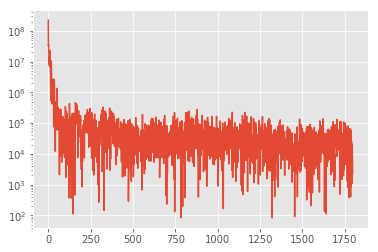

In [154]:
s = np.abs(np.fft.fft(phase[51,:,0,0]))**2

plt.plot(s[:len(s)>>1])
plt.yscale('log')
plt.show()

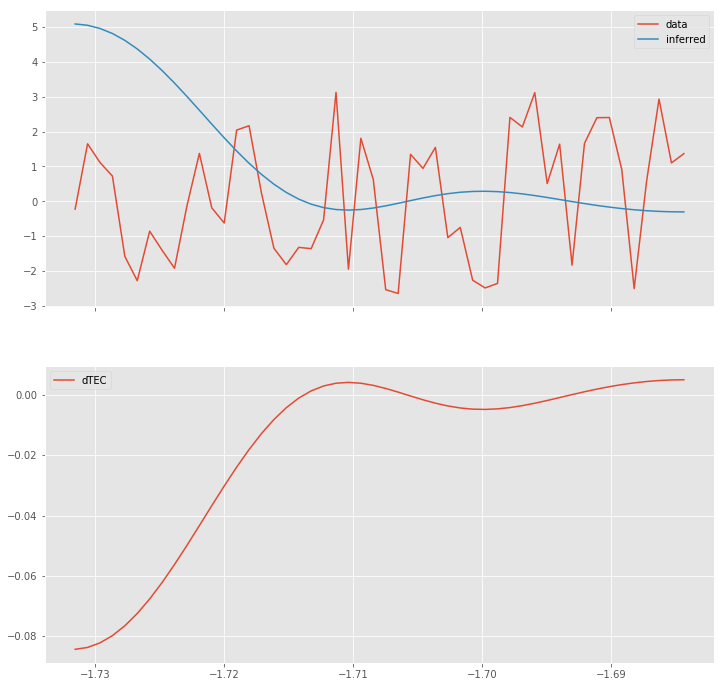

In [147]:
###
# reshape
ystar,stdstar = ystar.reshape([-1,1]), np.sqrt(varstar.reshape([-1,1]))
dtec_ystar,dtec_stdstar = dtec_ystar.reshape([-1,1]), np.sqrt(dtec_varstar.reshape([-1,1]))

fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(12,12))
plot_single(X_t[:50,:],w(phase[i,:50,0,0,None]),X_t[:50,:],ystar[:50,:],0*stdstar[:50,:], ax = axs[0])
axs[1].plot(X_t[:50,0],dtec_ystar[:50,0],label='dTEC')
# axs[1].fill_between(X_t[:,0],(dtec_ystar+dtec_stdstar)[:,0],(dtec_ystar-dtec_stdstar)[:,0],alpha=0.3)
axs[1].legend()
plt.show()

# Only direction (single time-step)

In [ ]:
try:
    @tf.RegisterGradient('WrapGrad')
    def _wrap_grad(op,grad):
        phi = op.inputs[0]
        return tf.ones_like(phi)*grad
except:
    pass#already defined

def wrap(phi):
    out = tf.atan2(tf.sin(phi),tf.cos(phi))
    with tf.get_default_graph().gradient_override_map({'Identity': 'WrapGrad'}):
        return tf.identity(out)
    
from heterogp.likelihoods import HeteroscedasticLikelihood
float_type = settings.float_type
class HeteroWrappedPhaseGaussian(HeteroscedasticLikelihood):
    def __init__(self, log_noise_latent, freq=140e6, name=None):
        super().__init__(log_noise_latent, name=name)
        self.num_gauss_hermite_points = 20
        self.freq = tf.convert_to_tensor(freq,dtype=settings.float_type,name='test_freq') # frequency the phase is calculated at for the predictive distribution
        self.tec_conversion = tf.convert_to_tensor(-8.4480e9,dtype=settings.float_type,name='tec_conversion') # rad Hz/ tecu
        self.tec2phase = tf.convert_to_tensor(self.tec_conversion / self.freq,dtype=settings.float_type,name='tec2phase')
    
    
    @params_as_tensors
    def logp(self, F, Y, freqs=None,hetero_variance=None,**unused_kwargs):
        """The log-likelihood function."""
        tec2phase = self.tec_conversion/freqs
        phase = F*tec2phase
        dphase = wrap(phase - wrap(Y)) # Ito theorem
        return densities.gaussian(dphase, tf.fill(tf.shape(F),tf.cast(0.,settings.float_type)), hetero_variance)

    @params_as_tensors
    def conditional_mean(self, F, eval_freq=None,hetero_variance=None, **unused_kwargs):  # pylint: disable=R0201
        """The mean of the likelihood conditioned on latent."""
        eval_freq = self.freq if eval_freq is None else eval_freq
        tec2phase = self.tec_conversion/eval_freq
        phase = F*tec2phase
        return phase

    @params_as_tensors
    def conditional_variance(self, F,hetero_variance=None, **unused_kwargs):
        return hetero_variance  
        
from heterogp.hgp import HGP

class WrappedPhaseHGP(HGP):
    def __init__(self,X, Y, Z, kern, likelihood, 
                 mean_function=gp.mean_functions.Zero, 
                 minibatch_size=None,
                 num_latent = None, 
                 num_samples=1,
                 num_data=None,
                 whiten=True):
        super(WrappedPhaseHGP,self).__init__(X, Y, Z, kern, likelihood, 
                 mean_function=mean_function, 
                 minibatch_size=minibatch_size,
                 num_latent = num_latent, 
                 num_samples=num_samples,
                 num_data=num_data,
                 whiten=whiten)

    def E_log_p_Y(self, X, Y):
        """
        Calculate the expectation of the data log likelihood under the variational distribution
         with MC samples
        """
        X = tf.tile(X[None,:,:],[self.num_samples,1,1])
        Fmean, Fvar = self._build_predict(X, full_cov=False, S=None)
        hetero_variance = tf.square(self.likelihood.hetero_noise(X))
        lik_freqs = self.Y[:,-1:]
        var_exp = self.likelihood.variational_expectations(Fmean, Fvar, Y[:,:-1], freqs = lik_freqs, hetero_variance=hetero_variance)  # S, N, D
        return tf.reduce_mean(var_exp, 0)  # N, D

    @params_as_tensors
    def KL_tensors(self):
        KL = [self.f_latent.KL()]
        if hasattr(self.likelihood,'log_noise_latent'):
            KL.append(self.likelihood.log_noise_latent.KL())
        if hasattr(self.f_latent.kern,'log_ls_latent'):
            KL.append(self.f_latent.kern.log_ls_latent.KL())
        if hasattr(self.f_latent.kern,'log_sigma_latent'):
            KL.append(self.f_latent.kern.log_sigma_latent.KL())
        return KL  

    @autoflow((float_type, [None, None]), (tf.int32, []))
    def predict_y(self, Xnew, num_samples):
        """
        Draws the predictive mean and variance at the points `X`
        num_samples times.
        X should be [N,D] and this returns [S,N,num_latent], [S,N,num_latent]
        """
        Xnew = tf.tile(Xnew[None,:,:],[num_samples,1,1])
        Fmean, Fvar = self._build_predict(Xnew, full_cov=False, S=None)
        hetero_variance = tf.square(self.likelihood.hetero_noise(Xnew))
        return self.likelihood.predict_mean_and_var(Fmean, Fvar, hetero_variance=hetero_variance)
    
    @autoflow((float_type, [None, None]), (tf.int32, []))
    def predict_dtec(self, Xnew, num_samples):
        """
        Draws the predictive mean and variance at the points `X`
        num_samples times.
        X should be [N,D] and this returns [S,N,num_latent], [S,N,num_latent]
        """
        Xnew = tf.tile(Xnew[None,:,:],[num_samples,1,1])
        return self._build_predict(Xnew, full_cov=False, S=None)

    @autoflow((float_type, [None, None]), (float_type, [None, None]), (tf.int32, []))
    def predict_density(self, Xnew, Ynew, num_samples):
        Xnew = tf.tile(Xnew[None,:,:],[num_samples,1,1])
        Fmean, Fvar = self._build_predict(Xnew, full_cov=False, S=None)
        hetero_variance = tf.square(self.likelihood.hetero_variance(Xnew))
        lik_freqs = Ynew[:,-1:]
        l = self.likelihood.predict_density(Fmean, Fvar, Ynew[:,:-1], freqs=lik_freqs, hetero_variance=hetero_variance)
        log_num_samples = tf.log(tf.cast(num_samples, float_type))
        return tf.reduce_logsumexp(l - log_num_samples, axis=0)

from heterogp.latent import Latent
def make_hetero_model(X,Y,freqs,M=None,minibatch_size=None):
    N, num_latent = Y.shape
    _, D = X.shape
    M = M or N
    Z = kmeans2(X, M, minit='points')[0] if N < 10000 else X[np.random.choice(N,size=M,replace=False),:]
    with gp.defer_build():
        
        noise_mean = gp.mean_functions.Constant(0.3)
        noise_kern = gp.kernels.RBF(1)
        noise_kern.variance.prior = gp.priors.Gaussian(0.3,0.3)
        
        log_noise_latent = Latent(X[np.random.choice(N,size=500,replace=False),:], 
                                  noise_mean, noise_kern, num_latent=1, whiten=False, name=None)
        # Define the likelihood
        likelihood = HeteroWrappedPhaseGaussian(log_noise_latent)
                
        kern_time = gp.kernels.RBF(1,active_dims=[0])
        kern_time.lengthscales = DTEC_prior_time_ls
#         kern_time.lengthscales.set_trainable(False)
        kern_time.lengthscales.prior = gp.priors.Gaussian(DTEC_prior_time_ls,DTEC_prior_time_ls**2)
        kern_time.variance.prior = gp.priors.Gaussian(0.,DTEC_prior_var)
        kern_space = gp.kernels.RBF(2,active_dims=[1,2])
        kern_space.lengthscales.prior = gp.priors.Gaussian(0.,DTEC_prior_dir_ls**2)
        kern_space.variance.set_trainable(False)
        kern = kern_time*kern_space
        mean = gp.mean_functions.Constant()
        
        model = WrappedPhaseHGP(X, Y, Z, kern, likelihood, 
                 mean_function=mean, 
                 minibatch_size=minibatch_size,
                 num_latent = num_latent-1, 
                 num_samples=1,
                 num_data=N,
                 whiten=False)
        model.compile()
    return model

def plot_single(X,Y,Xstar,Ystar,error, ax = None):
    if ax is None:
        fig,ax = plt.subplots(1,1)
    ax.plot(X[:,0],Y[:,0],label='data')
    ax.plot(Xstar[:,0],Ystar[:,0],label='inferred')
    ax.fill_between(Xstar[:,0],Ystar[:,0]+error[:,0],Ystar[:,0]-error[:,0],alpha=0.25)
    ax.legend()

def w(x):
    return np.arctan2(np.sin(x),np.cos(x))


iterations=10000
i = 51
k = 42

X = make_coord_array(X_t,X_d[:k,:],freqs[:,None])[:,:-1]# N, 3
Y = make_data_vec(w(phase[i,:,:k,:,None]),freqs)#N2

with tf.Session(graph=tf.Graph()) as sess:
    model = make_hetero_model(X,Y,freqs,M=4000,minibatch_size=128)
    
#     run_nat_grads_with_adam(model,1e-3,1e-1,iterations,callback=PrintAction(model,"Adam"))

    run_with_adam(model,1e-3,iterations,PrintAction(model,"Adam"))
    
    Xstar = make_coord_array(X_t,X_d[:k,:],freqs[:1,None])[:,:-1]
    ystar,varstar = model.predict_y(Xstar,100)#at 140MHz
    dtec_ystar,dtec_varstar = model.predict_dtec(Xstar,100)

# ###
# # reshape
# ystar,stdstar = ystar.reshape([100,1]), np.sqrt(varstar.reshape([100,1]))
# dtec_ystar,dtec_stdstar = dtec_ystar.reshape([100,1]), np.sqrt(dtec_varstar.reshape([100,1]))

# fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(12,12))
# plot_single(X_t[:100,:],w(phase[i,:100,0,0,None]),X_t[:100,:],ystar[:100,:],stdstar, ax = axs[0])
# axs[1].plot(X_t[:100,0],dtec_ystar[:100,0],label='dTEC')
# axs[1].fill_between(X_t[:100,0],(dtec_ystar+dtec_stdstar)[:100,0],(dtec_ystar-dtec_stdstar)[:100,0],alpha=0.3)
# axs[1].legend()
# plt.show()



In [ ]:
ystar = ystar.mean(0)
varstar = varstar.mean(0)
dtec_ystar = dtec_ystar.mean(0)
dtec_varstar = dtec_varstar.mean(0)

In [ ]:
###
# reshape
ystar,stdstar = ystar.reshape([-1,1]), np.sqrt(varstar.reshape([-1,1]))
dtec_ystar,dtec_stdstar = dtec_ystar.reshape([-1,1]), np.sqrt(dtec_varstar.reshape([-1,1]))

fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(12,12))
plot_single(X_t[:500,:],w(phase[i,:500,0,0,None]),X_t[:500,:],ystar[:500,:],0*stdstar[:500,:], ax = axs[0])
axs[1].plot(X_t[:500,0],dtec_ystar[:500,0],label='dTEC')
# axs[1].fill_between(X_t[:500,0],(dtec_ystar+dtec_stdstar)[:500,0],(dtec_ystar-dtec_stdstar)[:500,0],alpha=0.3)
axs[1].legend()
plt.show()